In [1]:
# Standard libraries
import os

# Third-party libraries
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor

# Custom modules
from bayesian_optimization import *
from data_loader import CropYieldDataLoader
from leave_one_year_out import yield_prediction
from utils import *

## **Data Loader**

In [ ]:
# Example usage:
target_region = ['Cherkaska', 'Chernihivska', 'Chernivetska', 'Dnipropetrovska', 'Donetska', 'Kharkivska', 'Khmelnytska', 'Kirovohradska', 
                 'Luhanska', 'Lvivska', 'Mykolaivska', 'Odeska', 'Poltavska', 'Rivnenska', 'Sumska', 'Ternopilska', 'Vinnytska', 
                 'Volynska', 'Zakarpatska', 'Zaporizka', 'Zhytomyrska']

n_regions = len(target_region)
region_names = target_region

years = np.arange(2010, 2023 + 1)
selected_years = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

combined_file_path = '/home/sehoon/Desktop/Sehoon/crop_yield/wheat/combined_data.csv'
crop_yield_file_path = '/home/sehoon/Desktop/Sehoon/crop_yield/data/crop_yield.csv'

data_loader = CropYieldDataLoader(target_region, combined_file_path, crop_yield_file_path)
data_loader.load_data()

X_selected, y_selected = data_loader.filter_years(selected_years)


result_save_path = '/home/sehoon/Desktop/Sehoon/crop_yield/results/wheat/11_20'
param_dir = '/home/sehoon/Desktop/Sehoon/crop_yield/results/wheat/yaml'  # Folder containing all YAML files
params_path = '/home/sehoon/Desktop/Sehoon/crop_yield/results/wheat/11_20/hyperparams'  # Folder to save results

## **Bayesian Optimization**

In [ ]:
param_spaces = load_param_spaces_from_dir(param_dir)

# Run BayesSearchCV for all models using RMSE
run_bayes_search(X_selected, y_selected, param_spaces, params_path, rmse_scorer)

## **ML**

1. X.shape: (308, 104)
- 21 regions * 14 years (2010 ~ 2023)
- 13 indicators * 8 months (3 ~ 10)
2. y.shape: (308,)
- wheat yield

### **SVM**

In [ ]:
estimator = SVR
model_name = 'svm'
metric_name = 'RMSE'

yield_prediction(estimator, params_path, model_name, metric_name, X_selected, y_selected, target_region, selected_years, result_save_path)

### **RF**

In [ ]:
estimator = RandomForestRegressor
model_name = 'rf'
metric_name = 'RMSE'

yield_prediction(estimator, params_path, model_name, metric_name, X_selected, y_selected, target_region, selected_years, result_save_path)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import time

# 목표 함수 정의: y = a * cos(b * X) + b * sin(a * X)
def func(params, x):
    a, b = params
    return a * np.cos(b * x) + b * np.sin(a * x)

# 잔차 함수 (최소화할 목표 함수)
def residuals(params, x, y):
    return y - func(params, x)

def newton_raphson_least_squares(x, y, initial_params, max_iter=1000):
    params = initial_params.copy()
    history = [params.copy()]  # 파라미터 변화 저장
    for i in range(max_iter):
        residuals_val = residuals(params, x, y)
        
        # Gradient 계산
        grad = np.array([
            -2 * np.sum(residuals_val * (np.cos(params[1] * x) - params[1] * x * np.sin(params[1] * x))),
            -2 * np.sum(residuals_val * (-params[0] * x * np.sin(params[1] * x) + np.cos(params[0] * x)))
        ])
        
        # Hessian Matrix 계산
        hessian = np.array([
            [
                2 * np.sum((np.cos(params[1] * x) - params[1] * x * np.sin(params[1] * x))**2),
                2 * np.sum(-(x * residuals_val) * (params[0] * x * np.sin(params[1] * x) - np.cos(params[0] * x)))
            ],
            [
                2 * np.sum(-(x * residuals_val) * (params[0] * x * np.sin(params[1] * x) - np.cos(params[0] * x))),
                2 * np.sum((params[0] * x * np.sin(params[1] * x) - np.cos(params[0] * x))**2)
            ]
        ])
        
        # Hessian이 역행렬을 구할 수 있는지 확인하고, 그렇지 않으면 종료
        try:
            hessian_inv = np.linalg.inv(hessian)
        except np.linalg.LinAlgError:
            print("Hessian is singular; stopping early.")
            break
        
        # Newton-Raphson 업데이트
        params -= hessian_inv @ grad
        history.append(params.copy())  # 파라미터 업데이트 후 저장
        
        # 변화가 미미하면 중단
        if np.linalg.norm(grad) < 1e-7:
            break
    return params, history  # history를 함께 반환

# 데이터 생성 (초기 데이터 포인트)
np.random.seed(0)
x_data = np.linspace(0, 2 * np.pi, 100)
a_true, b_true = 100, 102  # 실제 a, b 값
y_data = func([a_true, b_true], x_data) + np.random.normal(-1, 1, x_data.size)

# 전체 최적화 및 시각화 함수
def fit_and_plot(initial_params):
    # Levenberg-Marquardt (lm) 방법으로 피팅
    start_time = time.time()
    result_lm = least_squares(residuals, initial_params, args=(x_data, y_data), method='lm')
    lm_time = time.time() - start_time
    a_fit_lm, b_fit_lm = result_lm.x
    lm_history = result_lm.nfev  # LM 반복 횟수 (함수 평가 횟수)

    # Newton-Raphson 기반 최적화
    start_time = time.time()
    (a_fit_newton, b_fit_newton), newton_history = newton_raphson_least_squares(x_data, y_data, initial_params)
    newton_time = time.time() - start_time
    newton_iter = len(newton_history)  # 뉴튼 반복 횟수
    
    # 두 방법의 잔차 계산 (최종 적합 모델과의 차이)
    residual_lm = np.sum(residuals([a_fit_lm, b_fit_lm], x_data, y_data)**2)
    residual_newton = np.sum(residuals([a_fit_newton, b_fit_newton], x_data, y_data)**2)

    # 결과 시각화
    plt.figure(figsize=(18, 6))

    # 첫 번째 서브플롯 - Levenberg-Marquardt 방법
    plt.subplot(1, 3, 1)
    plt.plot(x_data, y_data, 'o', label='Data with noise', markersize=4)
    plt.plot(x_data, func([a_true, b_true], x_data), 'g--', label='True function')
    plt.plot(x_data, func(initial_params, x_data), 'r-', label='Initial guess')
    plt.plot(x_data, func([a_fit_lm, b_fit_lm], x_data), 'b-', label='LM Fitted curve')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.title("Levenberg-Marquardt Fit (method='lm')")

    # 두 번째 서브플롯 - Newton-Raphson 방법
    plt.subplot(1, 3, 2)
    plt.plot(x_data, y_data, 'o', label='Data with noise', markersize=4)
    plt.plot(x_data, func([a_true, b_true], x_data), 'g--', label='True function')
    plt.plot(x_data, func(initial_params, x_data), 'r-', label='Initial guess')
    plt.plot(x_data, func([a_fit_newton, b_fit_newton], x_data), 'm-', label='Newton Fitted curve')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.title("Newton-Raphson Least Squares Fit")

    # 세 번째 서브플롯 - 파라미터 이동 경로
    plt.subplot(1, 3, 3)
    newton_history_arr = np.array(newton_history)
    plt.plot(newton_history_arr[:, 0], newton_history_arr[:, 1], '-o', markersize=4, label="Newton Path")
    plt.scatter(a_true, b_true, color='green', marker='x', s=100, label="True Params")
    plt.scatter(initial_params[0], initial_params[1], color='red', marker='x', s=100, label="Initial Guess")
    plt.xlabel("Parameter a")
    plt.ylabel("Parameter b")
    plt.legend()
    plt.title("Parameter Space Trajectory (Newton-Raphson)")

    plt.tight_layout()
    plt.show()

    # 결과 출력
    print("초기 파라미터 추정치:", f"a = {initial_params[0]}, b = {initial_params[1]}")
    print(f"Levenberg-Marquardt 최적화된 파라미터: a = {a_fit_lm:.2f}, b = {b_fit_lm:.2f}")
    print(f"Newton-Raphson 최적화된 파라미터: a = {a_fit_newton:.2f}, b = {b_fit_newton:.2f}")
    print(f"실제 파라미터: a = {a_true}, b = {b_true}")
    print(f"Levenberg-Marquardt 잔차 제곱합: {residual_lm:.2f}")
    print(f"Newton-Raphson 잔차 제곱합: {residual_newton:.2f}")
    print(f"\n소요 시간 및 반복 횟수:")
    print(f"Levenberg-Marquardt 방법: {lm_time:.4f}초, 반복 횟수: {lm_history}")
    print(f"Newton-Raphson 방법: {newton_time:.4f}초, 반복 횟수: {newton_iter}")

# 예제 실행
fit_and_plot([99.5, 101.4])

### **Gradient Boosting**

In [ ]:
estimator = GradientBoostingRegressor
model_name = 'gb'
metric_name = 'RMSE'

yield_prediction(estimator, params_path, model_name, metric_name, X_selected, y_selected, target_region, selected_years, result_save_path)

### **DT**

In [ ]:
estimator = DecisionTreeRegressor
model_name = 'dt'
metric_name = 'RMSE'

yield_prediction(estimator, params_path, model_name, metric_name, X_selected, y_selected, target_region, selected_years, result_save_path)

## **KNN 회귀**

In [ ]:
estimator = KNeighborsRegressor
model_name = 'knn'
metric_name = 'RMSE'

yield_prediction(estimator, params_path, model_name, metric_name, X_selected, y_selected, target_region, selected_years, result_save_path)

## **XGBoost**

In [ ]:
estimator = XGBRegressor
model_name = 'xgb'
metric_name = 'RMSE'

yield_prediction(estimator, params_path, model_name, metric_name, X_selected, y_selected, target_region, selected_years, result_save_path)

## **Scatter Plot and Correlation**

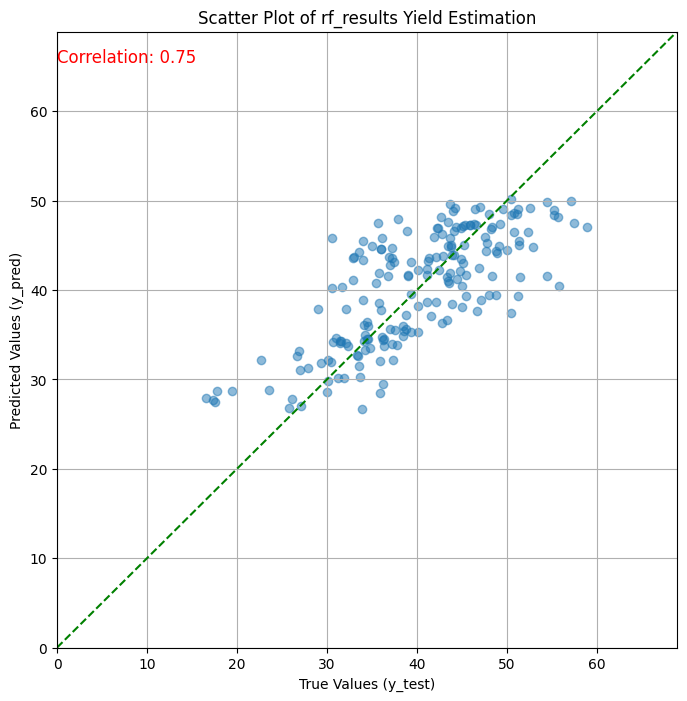

In [2]:
# Load the CSV file
file_path = '/home/sehoon/Desktop/Sehoon/crop_yield/results/wheat/12_20/rf_results.csv'
df = pd.read_csv(file_path)

# Extract the filename without extension for the plot title
file_name = os.path.splitext(os.path.basename(file_path))[0]

# Visualize results, print correlation, and R² value
scatterplot_visualization(df, file_name)

## **시각화**

In [ ]:
# Example usage
directory = '/home/sehoon/Desktop/Sehoon/crop_yield/results/wheat/12_20'  # Replace with your directory path
metric = 'RMSE'  # Replace with the desired metric (e.g., 'RMSE', 'MAE')
plot_metric_by_algorithm(directory, metric)